# Sample data for insurance portfolio optimisation

The problem of portfolio optimisation is to:

$$\min q \sum_i \sum_j x_i x_j \sigma_{ij} - \sum_i x_i \mu_i$$

$$s.t. \sum_i x_i = B$$

Here 

* $q>0$ is the risk appetite of the decision maker. 5% is a reasonable value for this case.
* $x_i$ is the decision variable indicating whether property i is included in the portfolio.
* $\sigma_{ij}$ represents the correlation between properties i and j.
* $\mu_i$ is the expected return on the property i, i.e., the premium, which we assume to be fixed (and given) in this case.
* B is the budget, i.e., how many properties a decision maker wants in its portfolio. 10% of the possible properties is a reasonable value for this case.

To create sample data, you could run the cell below.


In [576]:
from pennylane import numpy as np

#np.random.seed(42)
n_properties = 10
budget = 3


# Step 2: Generate premiums (mu)
mu = np.random.uniform(0.05, 0.15, n_properties)

# Step 3: Build a correlation matrix (sigma)
# Low correlation between selected properties
base_corr = np.random.uniform(0.1, 0.3, (n_properties, n_properties))
correlation_matrix = (base_corr + base_corr.T) / 2
np.fill_diagonal(correlation_matrix, 1)

# Step 4: Turn into covariance-like structure
sigma = correlation_matrix * np.outer(mu, mu)

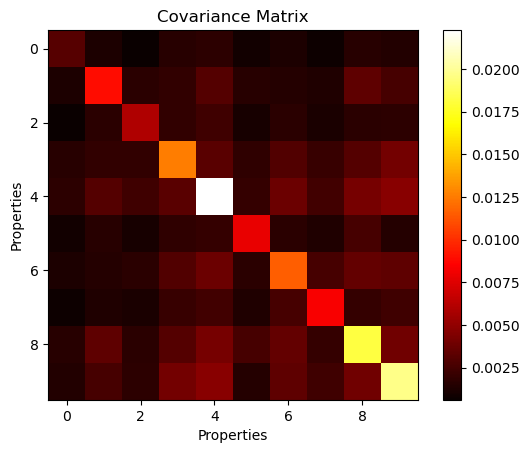

In [577]:
# plot sigma as image
import matplotlib.pyplot as plt

plt.imshow(sigma, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Covariance Matrix")
plt.xlabel("Properties")
plt.ylabel("Properties")
plt.show()

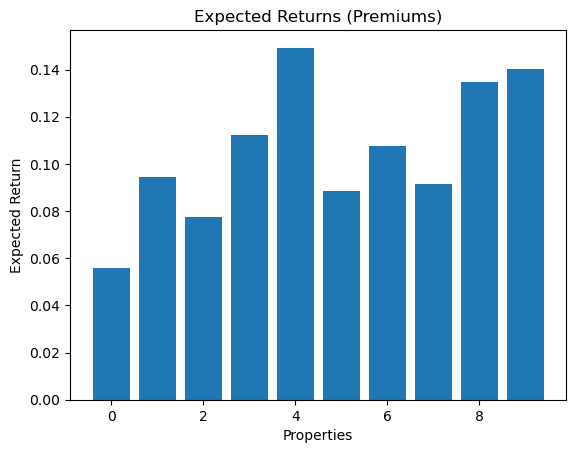

In [578]:
# Plot mu as bar chart
plt.bar(range(n_properties), mu)
plt.title("Expected Returns (Premiums)")
plt.xlabel("Properties")
plt.ylabel("Expected Return")
plt.show()

BUILD QUBO MATRIX

In [579]:
lambda_ = 0.1    # trade-off: reward return vs. minimize correlation
P = 100          # 10 is too low!
n = n_properties
k = budget

# Start with the covariance matrix as risk
Q = sigma.copy()

# Add premium (expected return) as a negative reward
for i in range(n):
    Q[i, i] -= lambda_ * mu[i]

# Add constraint penalty: (sum x_i - k)^2
for i in range(n):
    Q[i, i] += P * (1 - 2 * k)
    for j in range(n):
        if i != j:
            Q[i, j] += P


In [580]:
print(Q)

[[-500.0024667   100.00126705  100.00061785  100.00154931  100.00175155
   100.0008992   100.00128607  100.00072491  100.0015734   100.00145227]
 [ 100.00126705 -500.00052539  100.00170388  100.00189868  100.00303182
   100.00159115  100.0014744   100.00134495  100.00338129  100.00261639]
 [ 100.00061785  100.00170388 -500.00174073  100.00190062  100.00238456
   100.00107688  100.00165483  100.00115934  100.00168692  100.00173228]
 [ 100.00154931  100.00189868  100.00190062 -499.99863067  100.00322071
   100.00180816  100.00297293  100.00210316  100.00301699  100.00401938]
 [ 100.00175155  100.00303182  100.00238456  100.00322071 -499.99265058
   100.00197173  100.00376134  100.00245636  100.00415073  100.00468885]
 [ 100.0008992   100.00159115  100.00107688  100.00180816  100.00197173
  -500.00100754  100.00168383  100.00134548  100.00256924  100.00152122]
 [ 100.00128607  100.0014744   100.00165483  100.00297293  100.00376134
   100.00168383 -499.99920706  100.0026139   100.00353943 

In [581]:
J = np.zeros((n, n))
h = np.zeros(n)

for i in range(n):
    h[i] = -0.5 * Q[i, i]
    for j in range(i + 1, n):
        J[i, j] = 0.25 * Q[i, j]
        h[i] += 0.25 * Q[i, j]
        h[j] += 0.25 * Q[i, j]


In [582]:
import pennylane as qml

coeffs = []
obs = []

for i in range(n):
    coeffs.append(h[i])
    obs.append(qml.PauliZ(i))

for i in range(n):
    for j in range(i + 1, n):
        if J[i, j] != 0:
            coeffs.append(J[i, j])
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

H = qml.Hamiltonian(coeffs, obs)
print(H)

475.00401375231155 * Z(0) + 450.0045233376415 * Z(1) + 425.0037692274198 * Z(2) + 400.00360066714444 * Z(3) + 375.00058254354457 * Z(4) + 350.00228371469757 * Z(5) + 325.00197954056415 * Z(6) + 300.00147672032404 * Z(7) + 274.99865636885886 * Z(8) + 249.99717984736134 * Z(9) + 25.000316762668422 * (Z(0) @ Z(1)) + 25.000154461395272 * (Z(0) @ Z(2)) + 25.00038732626414 * (Z(0) @ Z(3)) + 25.000437888528783 * (Z(0) @ Z(4)) + 25.00022480072073 * (Z(0) @ Z(5)) + 25.00032151690623 * (Z(0) @ Z(6)) + 25.000181226459397 * (Z(0) @ Z(7)) + 25.000393349734825 * (Z(0) @ Z(8)) + 25.000363067773428 * (Z(0) @ Z(9)) + 25.000425970232573 * (Z(1) @ Z(2)) + 25.000474669519193 * (Z(1) @ Z(3)) + 25.000757955146643 * (Z(1) @ Z(4)) + 25.000397788412737 * (Z(1) @ Z(5)) + 25.00036859915998 * (Z(1) @ Z(6)) + 25.00033623765692 * (Z(1) @ Z(7)) + 25.000845323153133 * (Z(1) @ Z(8)) + 25.000654097178355 * (Z(1) @ Z(9)) + 25.000475154839872 * (Z(2) @ Z(3)) + 25.000596139974952 * (Z(2) @ Z(4)) + 25.00026922115265 * (Z(2

In [583]:
dev = qml.device("lightning.qubit", wires=n)

@qml.qnode(dev)
def circuit(params):
    for i in range(n):
        qml.RY(params[i], wires=i)
    for i in range(n):
        for j in range(i+1, n):
            qml.CNOT(wires=[i, j])

    return qml.expval(H)

(<Figure size 4900x1100 with 1 Axes>, <Axes: >)


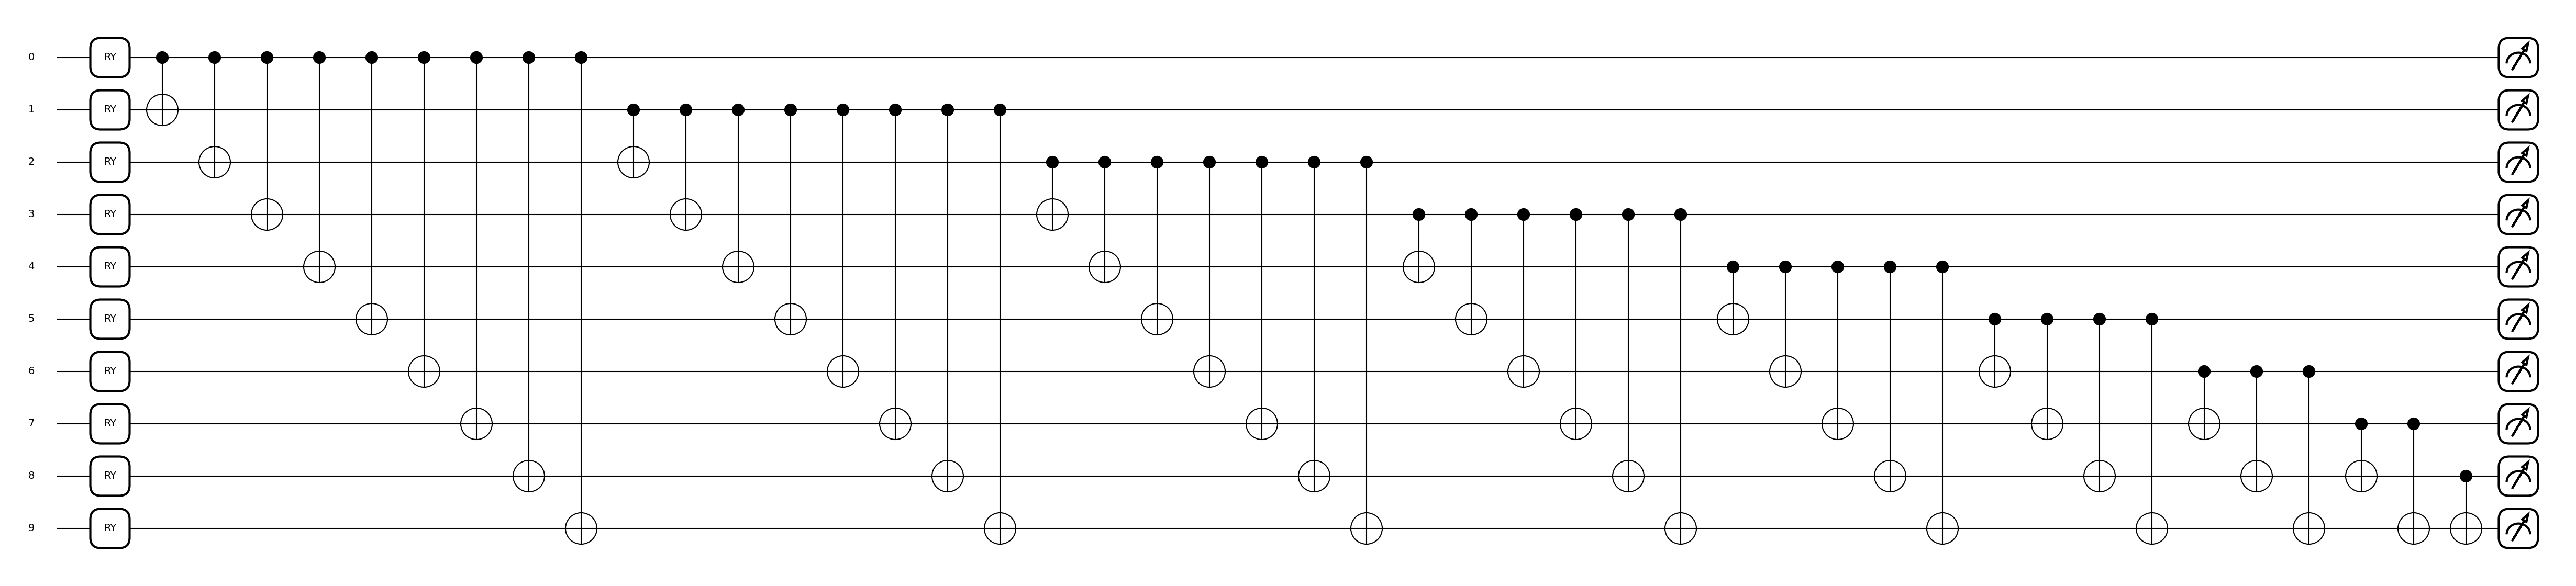

In [584]:
print(qml.draw_mpl(circuit, max_size=5)(np.zeros(n)))

In [585]:
def cost_fn(params):
    return circuit(params)  # this returns ⟨H⟩


In [586]:
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

# Create trainable parameters correctly
params = np.tensor(np.random.uniform(0, np.pi, size=n), requires_grad=True)

opt = AdamOptimizer(stepsize=0.2)
steps = 100

for i in range(steps):
    params = opt.step(cost_fn, params)
    if i % 10 == 0:
        energy = cost_fn(params)
        print(f"Step {i:3d} | Cost (Energy): {energy:.6f}")


/home/jacopo/anaconda3/envs/qml/lib/python3.12/site-packages/pennylane/devices/preprocess.py:251: UserWarning: Differentiating with respect to the input parameters of LinearCombination is not supported with the adjoint differentiation method. Gradients are computed only with regards to the trainable parameters of the circuit.

 Mark the parameters of the measured observables as non-trainable to silence this warning.
  warnings.warn(


Step   0 | Cost (Energy): -251.045822
Step  10 | Cost (Energy): -1520.131410
Step  20 | Cost (Energy): -2003.176820
Step  30 | Cost (Energy): -2465.311810
Step  40 | Cost (Energy): -2427.422608
Step  50 | Cost (Energy): -2490.487845
Step  60 | Cost (Energy): -2494.610183
Step  70 | Cost (Energy): -2496.773516
Step  80 | Cost (Energy): -2499.775393
Step  90 | Cost (Energy): -2499.719854


In [587]:
print(params)

[ 3.14604063e+00 -4.80440898e-03  3.16696102e+00  6.45214565e-03
  3.14127534e+00  4.47455006e-03  3.14297243e+00 -5.45878074e-04
  3.13254143e+00 -3.11368495e-02]


Let's sample now to find the optimal bitstring

In [588]:
dev = qml.device("default.qubit", wires=n, shots=1000)  # 👈 Add shots here

@qml.qnode(dev)
def sampling_circuit(params):
    for i in range(n):
        qml.RY(params[i], wires=i)
    for i in range(n - 1):
        qml.CNOT(wires=[i, i + 1])
    return qml.sample(wires=range(n))


In [589]:
samples = sampling_circuit(params)  # shape = (shots, n)
from collections import Counter

bitstrings = ["".join(str(b) for b in sample) for sample in samples]
counts = Counter(bitstrings)

# Print the most frequent samples
for bitstring, count in counts.most_common(5):
    print(f"{bitstring} -> {count} times")


1100110011 -> 1000 times


In [590]:
print(np.unique(samples, axis=0))    

[[1 1 0 0 1 1 0 0 1 1]]


In [591]:
def evaluate_energy(x):
    z = 1 - 2 * np.array(x)  # convert 0/1 → ±1
    energy = sum(h[i] * z[i] for i in range(n))
    energy += sum(J[i, j] * z[i] * z[j] for i in range(n) for j in range(i+1, n))
    return energy

# Get all sample energies
sample_energies = [(sample, evaluate_energy(sample)) for sample in samples]
best_sample = min(sample_energies, key=lambda x: x[1])[0]



In [592]:
print(evaluate_energy(best_sample))

-799.99671114293


In [593]:
print("Best decision vector X:", best_sample)

Best decision vector X: [1 1 0 0 1 1 0 0 1 1]


In [594]:
import numpy as np
import itertools

def cost_from_assignment(x, sigma, mu, q):
    """
    Compute the portfolio cost for a given binary assignment x.
    
    Parameters:
    -----------
    x     : array-like of shape (n,), with entries 0 or 1.
            x_i = 1 indicates property i is selected.
    sigma : array-like of shape (n, n)
            Covariance (or correlation scaled by mu's) matrix.
    mu    : array-like of shape (n,)
            Expected returns/premiums for each property.
    q     : float
            Risk appetite parameter.
    
    Returns:
    --------
    cost  : float, the cost for the assignment x.
            Lower cost indicates a better (more optimal) solution.
    """
    x = np.array(x, dtype=float)
    # Compute risk term: x^T sigma x
    risk = x @ sigma @ x
    # Compute returns term: sum_i x_i * mu_i
    returns = x @ mu
    # The cost function: risk scaled by q minus returns.
    cost = q * risk - returns
    return cost

def exhaustive_search(n, budget, q, sigma, mu):
    """
    Exhaustively searches over all binary assignments of length n
    with exactly `budget` ones, computing the cost for each,
    and returns the assignment with minimum cost.

    Parameters:
    -----------
    n       : int, number of properties (length of x).
    budget  : int, number of properties to select (number of ones).
    q       : float, risk appetite parameter.
    sigma   : array-like of shape (n, n), covariance-like matrix.
    mu      : array-like of shape (n,), expected returns.
    
    Returns:
    --------
    best_assignment : numpy array of shape (n,), the binary vector
                      corresponding to the optimal portfolio.
    best_cost       : float, the cost of the best_assignment.
    """
    best_cost = None
    best_assignment = None
    
    # Generate all combinations of indices to choose exactly `budget` properties
    for indices in itertools.combinations(range(n), budget):
        # Build a binary vector x where indices in the combination are 1
        x = np.zeros(n, dtype=int)
        x[list(indices)] = 1
        cost = cost_from_assignment(x, sigma, mu, q)
        if best_cost is None or cost < best_cost:
            best_cost = cost
            best_assignment = x.copy()
    
    return best_assignment, best_cost

# Example usage (assuming sigma, mu, and q have been defined):

# For example, using your generated data:
#q = 0.1
# (sigma and mu are defined in your sample data code block)
best_assignment, best_cost = exhaustive_search(n_properties, budget, 0.3, sigma, mu)

print("Exhaustively found best assignment (optimal portfolio):", best_assignment)
print("With cost:", best_cost)
print(cost_from_assignment(best_sample, sigma, mu, 0.3))
print(cost_from_assignment([0,0,1,0,1,0,0,0,1,1], sigma, mu, 0.3))

Exhaustively found best assignment (optimal portfolio): [0 0 0 0 1 0 0 0 1 1]
With cost: -0.3984751962569441
-0.6171732653920887
-0.470743308001975
